###  차례대로 돌려주세요

In [14]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.svm import SVC
import warnings
import joblib
import pickle
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression,  LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer

data = pd.read_excel("../datasets/DB_0531_1740(태환).xlsx")

data.fillna(0, inplace=True)
column_list=['유동비율', '부채비율',  'new_시총', '영업이익률', 'ROA', 
       '총자산회전율',  '매출액증가율',  '총자산증가율','new_평균근속연수' 
,'new_기업존속연수', '비정규직비율', '여성고용률', "자산/기말인원"]

x = data[column_list]
st = StandardScaler()
x= st.fit_transform(x)
x=pd.DataFrame(x, columns=column_list)
df_17_20 = x[data['회계년도'].isin([2017,2018,2019,2020])] #train/test
df_21 = x[data['회계년도'] == 2021] #validate
y = data['K1_Score_ad']
y = y.apply(lambda x: 1 if(x=="부실" or x=="판정보류") else 0)
y_17_20=y[data['회계년도'].isin([2017,2018,2019,2020])] #train/test
y_21 = y[data['회계년도'] == 2021] #validate
X_train=df_17_20
X_test=df_21
y_train=y_17_20
y_test =y_21



# 언더샘플링
X_train_samp, y_train_samp = CondensedNearestNeighbour(random_state=0).fit_resample(X_train, y_train)
# X_test_samp,y_test_samp = CondensedNearestNeighbour(random_state=0).fit_resample(X_test, y_test)


# X_train_samp= st.fit_transform(X_train_samp)
# X_test_samp= st.fit_transform(X_test)

### 머신러닝 모델링 최적 하이퍼 파라미터에 따른 Best Score 확인

* 총 11가지의 분류 모델을 GridSearch cv를 통해 최적 파라미터를 찾고 교차검증을 실시하여 

* 각 분류 모델은 중요하게 여겨지는 파라미터들로 구성되어 있습니다.

* 또한 임계점에 따른 정확도, 정밀도, 재현율, f1-score을 확인 할 수 있습니다.

모델명: CatBoostClassifier
학습 데이터 최적 파라미터: {'depth': 4, 'eval_metric': 'Accuracy', 'iterations': 600, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'MultiClass'}
학습 데이터 최고 정확도: 0.711
예측 정확도: 0.898


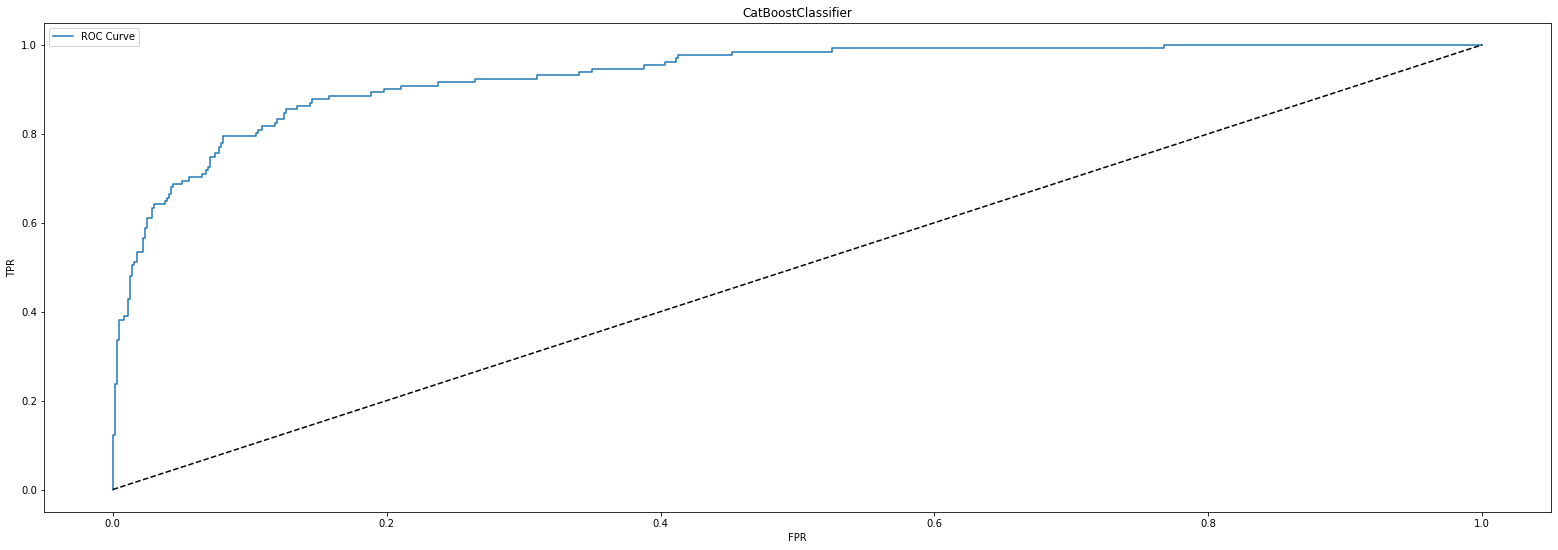

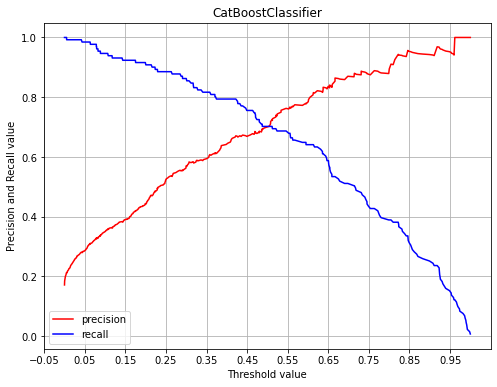

{'depth': 4, 'eval_metric': 'Accuracy', 'iterations': 600, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'MultiClass'}
                 models  Accuracy  Precision   Recall  F1 score  Auc_Score
0.5  CatBoostClassifier     0.898    0.70229  0.70229   0.70229   0.931877


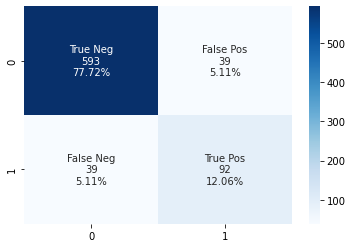

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

df = pd.DataFrame(columns =['models','Accuracy','Precision', 'Recall', 'F1 score','Auc_Score'])

list = ["CatBoostClassifier"]
for i in list:

# def grid(i):
  

                   
  # if i == "XGBClassifier":
  #       dt=XGBClassifier(random_state=0)
  #       parameters={'n_estimators':[4000], 'learning_rate':[0.001], 'max_depth':[3]}
        
  if i == "CatBoostClassifier":
        dt=CatBoostClassifier(random_state=0)
        parameters={'iterations': [600],
          'depth': [4],
          'loss_function': ['MultiClass'],
          'l2_leaf_reg': np.logspace(-20,-19),
          'leaf_estimation_iterations': [10],
           'eval_metric': ['Accuracy'],
          'logging_level':['Silent']
         }
       
  
  figure = plt.figure(figsize=(27, 9))

  grid_dt  = GridSearchCV(dt, param_grid = parameters, cv=5, refit =True, n_jobs=-1)
  grid_dt.fit(X_train_samp, y_train_samp )

  joblib.dump(grid_dt, 'model_220531_xgb.pkl')
  print("모델명: %s" %i)
  print(f"학습 데이터 최적 파라미터: {grid_dt.best_params_}")
  print(f"학습 데이터 최고 정확도: {grid_dt.best_score_:.3f}")

  estimator = grid_dt.best_estimator_
  y_pred = pd.DataFrame(estimator.predict(X_test))
  y_pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
  print(f"예측 정확도: {accuracy_score(y_test, y_pred):.3f}")

  prediction = pd.concat([y_pred_probability, y_pred], axis = 1)

  prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
  # print(prediction)
  # prediction.to_csv("../datasets/predictproba/{}.csv".format(i),index = False)
  pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
  b= round(accuracy_score(y_test, y_pred),3)
  FPRs, TPRs, thresholds = roc_curve(y_test, pred_proba_1)
  


  thresholds = [0.5]
  
#   thresholds = [0.5]

  def get_f1_score(y_test, pred_proba_1,thresholds):
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]
   

    for threshold in thresholds:
          
          

      binarizer = Binarizer(threshold = threshold)
      # 임계점 지정하여 Binariazer() 객체 생성
      pred_proba = binarizer.fit_transform(pred_proba_1)
      # 임계점을 기준으로 데이터 변환

      precision = precision_score(y_test, pred_proba)
      recall = recall_score(y_test, pred_proba)
      f1score = f1_score(y_test, pred_proba)
      auc_score=roc_auc_score(y_test, pred_proba_1)

      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1score)
      auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"models":i,"Accuracy":b,"Precision": precisions,
                                  "Recall": recalls,
                                  "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    

    results.sort_values("F1 score", ascending=False, inplace=True)
    new_model_df= results.iloc[:1]
    global df
    df = pd.concat([df,new_model_df])

    from sklearn.metrics import precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_1)
      

    plt.plot(FPRs, TPRs, label = "ROC Curve")
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel("FPR")
            # x축명
    plt.ylabel("TPR")
            # y축명
    plt.title(i)
    plt.legend()

    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
      # threshold의 구간이 몇 개로 나뉘어져 있는지 확인
    plt.plot(thresholds, precisions[0:threshold_boundary], color = "red", label = "precision")
      # x축이 threshold, y축이 precision인 그래프
    plt.plot(thresholds, recalls[0:threshold_boundary], color = "blue", label = "recall")

    start, end = plt.xlim()
      # x축과 y축의 범위를 얻어 각각 start와 end로 반환
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
      # x축의 눈금을 start부터 end까지 0.1 간격으로 표시

    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.title(i)
    plt.legend()
    plt.grid()
    plt.show()
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    # cf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
    #         fmt='.2%', cmap='Blues')
    print(grid_dt.best_params_)
    print(grid_dt.best_estimator_)
 
    return df
  print(get_f1_score(y_test, pred_proba_1,thresholds))
  
  print("="*80)


### 예측값 실제값 비교 데이터 프레임 생성 

In [5]:
data = pd.read_excel("../datasets/DB_0531_1740(태환).xlsx")
data.fillna(0, inplace=True)

column_list=['회사명','유동비율', '부채비율',  'new_시총', '영업이익률', 'ROA', 
       '총자산회전율',  '매출액증가율',  '총자산증가율','new_평균근속연수' 
,'new_기업존속연수', '비정규직비율', '여성고용률', "자산/기말인원"]

x = data[column_list]
x=pd.DataFrame(x)
x.head()

df_21 = x[data['회계년도'] == 2021] #validate
df_21.reset_index(drop=True,inplace=True)
df_21 = df_21.set_index("회사명")

st = StandardScaler().fit_transform(df_21.values)
X_test=pd.DataFrame(st, index = df_21.index, columns=df_21.columns)
X_test.head()


X_test_index = X_test.reset_index(drop=False)
X_test_index.drop(['유동비율', '부채비율',  'new_시총', '영업이익률', 'ROA', 
       '총자산회전율',  '매출액증가율',  '총자산증가율','new_평균근속연수' 
,'new_기업존속연수', '비정규직비율', '여성고용률', "자산/기말인원"],axis=1, inplace=True)

X_test_index

,회사명
0,삼천당제약(주)
1,(주)중앙에너비스
2,신라섬유(주)
3,안국약품(주)
4,무림에스피(주)
...,...
758,(주)원익아이피에스
759,(주)유니테크노
760,(주)코스메카코리아
761,오션브릿지(주)


In [6]:
y_pred = pd.DataFrame(estimator.predict(X_test.values))
y_pred_probability = pd.DataFrame(estimator.predict_proba(X_test.values))
print(f"예측 정확도: {accuracy_score(y_test, y_pred):.3f}")
prediction = pd.concat([y_pred_probability, y_pred], axis = 1)
prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
prediction

예측 정확도: 0.887


,Negative(0),Positive(1),y_pred
0,0.473265,0.526735,1
1,0.976133,0.023867,0
2,0.200815,0.799185,1
3,0.936856,0.063144,0
4,0.981147,0.018853,0
...,...,...,...
758,0.940032,0.059968,0
759,0.765905,0.234095,0
760,0.967630,0.032370,0
761,0.981693,0.018307,0


In [7]:
#실제 부도 값 데이터 
y_test_index = y_test.reset_index(drop=False)
y_test_index.drop(['index'],axis=1, inplace=True)
y_test_index

,K1_Score_ad
0,0
1,0
2,1
3,0
4,0
...,...
758,0
759,0
760,0
761,0


In [8]:
#인덱스 기준으로 병합 
probability = pd.merge(X_test_index, prediction, left_index=True, right_index=True)
probability = pd.merge(probability, y_test_index, left_index=True, right_index=True)
probability

,회사명,Negative(0),Positive(1),y_pred,K1_Score_ad
0,삼천당제약(주),0.473265,0.526735,1,0
1,(주)중앙에너비스,0.976133,0.023867,0,0
2,신라섬유(주),0.200815,0.799185,1,1
3,안국약품(주),0.936856,0.063144,0,0
4,무림에스피(주),0.981147,0.018853,0,0
...,...,...,...,...,...
758,(주)원익아이피에스,0.940032,0.059968,0,0
759,(주)유니테크노,0.765905,0.234095,0,0
760,(주)코스메카코리아,0.967630,0.032370,0,0
761,오션브릿지(주),0.981693,0.018307,0,0


In [9]:
probability.to_excel('prediction_with_predict_proba(지현)_0531_2112.xlsx')

In [10]:
probability_name = probability.set_index("회사명")
probability_name

,Negative(0),Positive(1),y_pred,K1_Score_ad
회사명,,,,
삼천당제약(주),0.473265,0.526735,1,0
(주)중앙에너비스,0.976133,0.023867,0,0
신라섬유(주),0.200815,0.799185,1,1
안국약품(주),0.936856,0.063144,0,0
무림에스피(주),0.981147,0.018853,0,0
...,...,...,...,...
(주)원익아이피에스,0.940032,0.059968,0,0
(주)유니테크노,0.765905,0.234095,0,0
(주)코스메카코리아,0.967630,0.032370,0,0


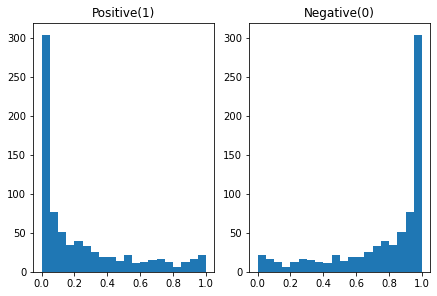

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
n_bins = 20
axes[0].set_title("Positive(1)")
axes[0].hist(probability_name['Positive(1)'], bins=n_bins)
axes[1].set_title("Negative(0)")
axes[1].hist(probability_name['Negative(0)'], bins=n_bins)
plt.show()

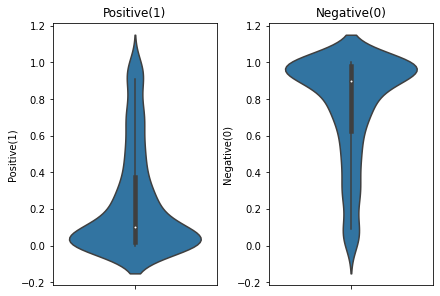

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
sns.violinplot(y=probability['Positive(1)'], ax = axes[0])
sns.violinplot(y=probability['Negative(0)'], ax = axes[1])
axes[0].set_title("Positive(1)")
axes[1].set_title("Negative(0)")
plt.show()

